In [2]:
# # 1️⃣ Create a new virtual environment (name it 'venv_tf' or anything)
# !python -m venv venv_face_identify
#
# # 2️⃣ Activate it (Windows-specific)
# !venv_face_identify\Scripts\activate
#
# # 3️⃣ Upgrade pip and install Jupyter into this venv
# !venv_face_identify\Scripts\python -m pip install --upgrade pip
# !venv_face_identify\Scripts\python -m pip install jupyter ipykernel
#
# # 4️⃣ Add this environment as a Jupyter kernel
# !venv_face_identify\Scripts\python -m ipykernel install --user --name=venv_face_identify --display-name "Python (venv_face_identify)"


In [3]:
#%pip install numpy pandas matplotlib tensorflow torch facenet-pytorch scikit-learn opencv-python tqdm pillow


In [4]:
# BLOCK 1 — Configuration Block (edit only DATA_ROOT)
# Directory/Path Define

DATA_ROOT = "human_face_dataset/pins_face_recognition"  # << set this to your dataset folder (one subfolder per person)
# Block 1 — Imports & configuration
from pathlib import Path
import os, time, pickle, hashlib
import numpy as np
from math import ceil
from tqdm import tqdm
from collections import defaultdict

# ---------- EDIT IF NEEDED ----------
# Set DATA_ROOT to the folder that contains one folder per person (images inside)
DATA_ROOT = "human_face_dataset/pins_face_recognition"
# ------------------------------------

# Cache & artifact locations
CACHE_DIR = Path('./embeddings_cache'); CACHE_DIR.mkdir(exist_ok=True)
EMB_FILE = CACHE_DIR / 'X_emb.npy'
LBL_FILE = CACHE_DIR / 'y_lbl.npy'
PATHS_FILE = CACHE_DIR / 'paths.npy'
CLF_FILE = CACHE_DIR / 'svc_model_retrained.pkl'
CENTROIDS_FILE = CACHE_DIR / 'centroids.npy'
CLASSES_FILE = CACHE_DIR / 'classes.npy'

# Image extensions considered
EXTS = {'.jpg', '.jpeg', '.png'}
print("DATA_ROOT:", DATA_ROOT)



DATA_ROOT: human_face_dataset/pins_face_recognition


In [5]:
# Block 2 — Imports and Model initialization (facenet-pytorch)
try:
    from facenet_pytorch import MTCNN, InceptionResnetV1
    import torch
    import cv2
    from PIL import Image
except Exception as e:
    raise ImportError("Missing packages. Run pip install facenet-pytorch torch torchvision opencv-python scikit-learn tqdm matplotlib pillow") from e

device = 'cpu'
mtcnn = MTCNN(keep_all=False, device=device)          # detector + alignment
resnet = InceptionResnetV1(pretrained='vggface2').eval()  # embedding model (512-d)
print("Models ready. Device:", device)


Models ready. Device: cpu


In [6]:
# BLOCK 3: Move duplicate files into ./duplicates/ (safe)
from pathlib import Path
import shutil

# `dupes` is the dict you produced mapping md5 -> [paths], or re-find below
def find_duplicates(paths):
    import hashlib
    from collections import defaultdict
    def h(p):
        m = hashlib.md5()
        with open(p,'rb') as f:
            for chunk in iter(lambda: f.read(8192), b''):
                m.update(chunk)
        return m.hexdigest()
    D = defaultdict(list)
    for p in paths:
        D[h(p)].append(p)
    return {k:v for k,v in D.items() if len(v)>1}

# Build paths list (adjust root)
root = Path(r'D:\DATA_SCIENCE\My_Projects\testing\human_face_identify\pins_face_recognition')
paths = [str(p) for p in root.rglob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')]
dupes = find_duplicates(paths)

outdir = Path('./duplicates'); outdir.mkdir(exist_ok=True)
moved = 0
for h, lst in dupes.items():
    keep = lst[0]            # keep first occurrence
    for p in lst[1:]:
        target = outdir / Path(p).name
        # avoid name collisions
        i = 1
        while target.exists():
            target = outdir / f"{Path(p).stem}_{i}{Path(p).suffix}"
            i += 1
        shutil.move(p, str(target))
        moved += 1
print(f"Moved {moved} duplicate files to {outdir}. Kept first occurrence of each duplicated image.")


Moved 0 duplicate files to duplicates. Kept first occurrence of each duplicated image.


In [7]:
# Block 4 — Data Count & Define Image Path for the operation
# Build image_paths and labels and save to cache (paths.npy)

from pathlib import Path
ROOT = Path(DATA_ROOT)
image_paths = [str(p) for p in sorted(ROOT.rglob('*')) if p.suffix.lower() in EXTS]
labels = [Path(p).parent.name for p in image_paths]
print("Classes found:", len(set(labels)), "Total images:", len(image_paths))
# Save list of paths to allow deduping later or resume
np.save(PATHS_FILE, np.array(image_paths, dtype=object))
print("Saved paths to", PATHS_FILE)


Classes found: 105 Total images: 17534
Saved paths to embeddings_cache\paths.npy


In [8]:
# Block 5: (Embedding Block)
# Batched, resumable extraction to EMB_FILE / LBL_FILE (overwrite/resume)

import numpy as np, torch
from PIL import Image
from math import ceil
from tqdm import tqdm

# parameters: tune for your machine
BATCH_SIZE = 48     # try 16/32/48/64 depending on RAM
SAVE_EVERY = 1      # save after this many batches
MAX_SIDE = 640      # resize max side for speed; lower to 480 if needed

# load list of all paths
image_paths = list(np.load(PATHS_FILE, allow_pickle=True))
n_total = len(image_paths)

# resume from cache if exists
if EMB_FILE.exists() and LBL_FILE.exists():
    X_cached = np.load(EMB_FILE)
    y_cached = np.load(LBL_FILE, allow_pickle=True)
    start_idx = len(y_cached)
    X_list = [X_cached[i] for i in range(len(X_cached))]
    y_list = [y_cached[i] for i in range(len(y_cached))]
    print(f"Resuming from cache: {start_idx} embeddings loaded.")
else:
    X_list = []
    y_list = []
    start_idx = 0

def safe_open_resize(path, max_side=MAX_SIDE):
    try:
        im = Image.open(path).convert('RGB')
        w,h = im.size
        s = max(w,h)
        if s > max_side:
            scale = max_side / s
            im = im.resize((int(w*scale), int(h*scale)), Image.BILINEAR)
        return im
    except Exception:
        return None

pairs = image_paths[start_idx:]
n = len(pairs)
if n == 0:
    print("No new images to process.")
else:
    n_batches = ceil(n / BATCH_SIZE)
    print(f"Processing {n} images in {n_batches} batches (batch_size={BATCH_SIZE})")
    bad_files = []
    batch_count = 0
    t_total = time.time()
    for b in tqdm(range(n_batches), desc='Batches'):
        s = b * BATCH_SIZE
        e = min(s + BATCH_SIZE, n)
        batch_paths = pairs[s:e]
        pil_imgs = []
        pil_labels = []
        real_paths = []
        for path in batch_paths:
            im = safe_open_resize(path)
            if im is None:
                bad_files.append(path)
                continue
            pil_imgs.append(im)
            pil_labels.append(Path(path).parent.name)
            real_paths.append(path)
        if not pil_imgs:
            batch_count += 1
            continue

        # try batch detection; fallback to per-image if needed
        faces = None
        try:
            faces = mtcnn(pil_imgs)
        except Exception as ex:
            faces = None
            # fallback will run below

        face_tensors = []
        valid_labels = []
        if isinstance(faces, torch.Tensor):
            # tensor -> all faces detected and aligned
            for i in range(faces.shape[0]):
                f = faces[i].unsqueeze(0)
                face_tensors.append(f)
                valid_labels.append(pil_labels[i])
        else:
            # fallback to per-image detection
            for im, lab, path in zip(pil_imgs, pil_labels, real_paths):
                try:
                    f = mtcnn(im)
                    if f is None:
                        bad_files.append(path)
                        continue
                    if f.dim() == 3:
                        f = f.unsqueeze(0)
                    face_tensors.append(f)
                    valid_labels.append(lab)
                except Exception:
                    bad_files.append(path)
                    continue

        if not face_tensors:
            batch_count += 1
            if batch_count % SAVE_EVERY == 0 and len(y_list) > 0:
                np.save(EMB_FILE, np.vstack(X_list))
                np.save(LBL_FILE, np.array(y_list, dtype=object))
            continue

        face_batch = torch.cat(face_tensors, dim=0)
        try:
            with torch.no_grad():
                emb_batch = resnet(face_batch).cpu().numpy()
        except Exception:
            # per-item embedding fallback
            emb_batch = []
            for ft in face_tensors:
                try:
                    with torch.no_grad():
                        e = resnet(ft).cpu().numpy().reshape(-1)
                    emb_batch.append(e)
                except Exception:
                    emb_batch.append(None)
            filtered = [(e, lab) for e, lab in zip(emb_batch, valid_labels) if e is not None]
            if not filtered:
                batch_count += 1
                continue
            emb_batch = np.vstack([f[0] for f in filtered])
            valid_labels = [f[1] for f in filtered]

        for emb, lab in zip(emb_batch, valid_labels):
            X_list.append(emb.astype('float32'))
            y_list.append(lab)

        batch_count += 1
        if batch_count % SAVE_EVERY == 0:
            np.save(EMB_FILE, np.vstack(X_list))
            np.save(LBL_FILE, np.array(y_list, dtype=object))
            t_elapsed = time.time() - t_total
            processed = len(y_list)
            rate = processed / t_elapsed if t_elapsed > 0 else 0
            print(f"Saved cache: {len(y_list)} embeddings; rate {rate:.2f} emb/s")

    # final save
    if len(X_list) > 0:
        X = np.vstack(X_list).astype('float32')
        y = np.array(y_list, dtype=object)
        np.save(EMB_FILE, X)
        np.save(LBL_FILE, y)
        np.save(PATHS_FILE, np.array(image_paths, dtype=object))  # ensure paths saved
        print("Done. Extracted embeddings:", X.shape)
    else:
        print("No embeddings extracted in this run.")

    if bad_files:
        bad_txt = CACHE_DIR / 'bad_files.txt'
        with open(bad_txt, 'w', encoding='utf-8') as f:
            for p in sorted(set(bad_files)):
                f.write(p + "\n")
        print(f"{len(set(bad_files))} problematic files logged to {bad_txt}")


Resuming from cache: 17534 embeddings loaded.
No new images to process.


In [9]:
# Block 6 — deduplicate embeddings using file MD5 (optional)
if not EMB_FILE.exists() or not PATHS_FILE.exists():
    print("Embeddings or paths missing. Run Block 5 first.")
else:
    X = np.load(EMB_FILE)
    y = np.load(LBL_FILE, allow_pickle=True)
    paths = list(np.load(PATHS_FILE, allow_pickle=True))
    print("Loaded:", X.shape, len(paths))
    seen = {}
    keep_idx = []
    for i, p in enumerate(paths):
        try:
            h = hashlib.md5(open(p, 'rb').read()).hexdigest()
        except Exception:
            continue
        if h in seen:
            continue
        seen[h] = i
        keep_idx.append(i)
    print("Unique images:", len(keep_idx), "of", len(paths))
    X_new = X[keep_idx]
    y_new = y[keep_idx]
    paths_new = [paths[i] for i in keep_idx]
    np.save(CACHE_DIR / 'X_emb_dedup.npy', X_new)
    np.save(CACHE_DIR / 'y_lbl_dedup.npy', y_new)
    np.save(CACHE_DIR / 'paths_dedup.npy', np.array(paths_new, dtype=object))
    print("Saved deduplicated embeddings to embeddings_cache/*.")
    # If you want to use deduped files as main, replace originals (manual step)


Loaded: (17534, 512) 17534
Unique images: 17533 of 17534
Saved deduplicated embeddings to embeddings_cache/*.


In [ ]:
################################################################################
# Block 6A - Check Class Balance (FAST - no processing needed)
################################################################################
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Load existing embeddings and labels
X = np.load(EMB_FILE)
y = np.load(LBL_FILE, allow_pickle=True)

# Count samples per class
class_counts = Counter(y)
class_counts_sorted = sorted(class_counts.items(), key=lambda x: x[1])

# Statistics
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
mean_samples = np.mean(list(class_counts.values()))
median_samples = np.median(list(class_counts.values()))

print("="*80)
print("📊 CLASS BALANCE ANALYSIS")
print("="*80)
print(f"Total classes: {len(class_counts)}")
print(f"Total samples: {len(y)}")
print(f"Min samples per class: {min_samples}")
print(f"Max samples per class: {max_samples}")
print(f"Mean samples per class: {mean_samples:.1f}")
print(f"Median samples per class: {median_samples:.1f}")
print(f"Imbalance ratio: {max_samples/min_samples:.2f}x")

# Define balance threshold
BALANCE_THRESHOLD = 1.5  # If max/min > 1.5x, consider imbalanced
IS_BALANCED = (max_samples / min_samples) <= BALANCE_THRESHOLD

if IS_BALANCED:
    print(f"\n✅ Dataset is BALANCED (ratio {max_samples/min_samples:.2f}x ≤ {BALANCE_THRESHOLD}x)")
    print("   No augmentation needed!")
else:
    print(f"\n⚠️ Dataset is IMBALANCED (ratio {max_samples/min_samples:.2f}x > {BALANCE_THRESHOLD}x)")
    print("   Augmentation recommended! Run Block 6B below.")

# Show classes with fewest samples
print("\n" + "="*80)
print("📉 CLASSES WITH FEWEST SAMPLES (Bottom 10)")
print("="*80)
for class_name, count in class_counts_sorted[:10]:
    print(f"  {class_name}: {count} samples")

# Show classes with most samples
print("\n" + "="*80)
print("📈 CLASSES WITH MOST SAMPLES (Top 10)")
print("="*80)
for class_name, count in class_counts_sorted[-10:]:
    print(f"  {class_name}: {count} samples")

# Visualize distribution
plt.figure(figsize=(15, 5))
counts = [count for _, count in class_counts_sorted]
plt.bar(range(len(counts)), counts, color='skyblue', edgecolor='black')
plt.axhline(y=mean_samples, color='red', linestyle='--', label=f'Mean: {mean_samples:.1f}')
plt.axhline(y=median_samples, color='green', linestyle='--', label=f'Median: {median_samples:.1f}')
plt.xlabel('Class Index (sorted by count)')
plt.ylabel('Number of Samples')
plt.title('Samples per Class Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Distribution plot saved as: class_distribution.png")
print("="*80)

# Save balance report
balance_report = []
for class_name, count in sorted(class_counts.items()):
    balance_report.append({
        'class': class_name,
        'samples': count,
        'percentage': f"{count/len(y)*100:.2f}%",
        'status': '✓ Good' if count >= mean_samples*0.7 else '⚠ Low'
    })

balance_df = pd.DataFrame(balance_report)
balance_df.to_csv('class_balance_report.csv', index=False)
print(f"✅ Detailed balance report saved as: class_balance_report.csv")



In [ ]:
################################################################################
# Block 6B - Smart Augmentation (Embedding-Level) (cache-aware incremental augment)
################################################################################
print("\n\n" + "="*80)
print("🔄 SMART AUGMENTATION (Embedding-Level)")
print("="*80)

# ---- imports ----
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import sys, os

# ---- Helpers: locate CACHE_DIR (try existing variable else default) ----
try:
    CACHE_DIR
except NameError:
    CACHE_DIR = Path('embeddings_cache')
CACHE_DIR = Path(CACHE_DIR)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# candidate paths (try to preserve earlier names if present in workspace)
emb_cache = CACHE_DIR / 'X_emb_augmented.npy'
lbl_cache = CACHE_DIR / 'y_lbl_augmented.npy'
paths_cache = CACHE_DIR / 'paths_augmented.npy'
augmentation_report_csv = Path('augmentation_report.csv')

# Try loading embeddings/labels/paths either from workspace variables or files
def _load_var_or_file(varnames, candidates, label):
    g = globals()
    for n in varnames:
        if n in g and g[n] is not None:
            return g[n], f"variable '{n}'"
    for c in candidates:
        if c is None:
            continue
        p = Path(c)
        if p.exists():
            val = np.load(p, allow_pickle=True)
            return val, f"file: {p}"
    raise NameError(f"{label} not found (tried vars {varnames} and files {candidates})")

# Attempt to find X, y, paths in globals or in common files
emb_candidates = [emb_cache, 'X_emb.npy', 'X.npy', 'embeddings.npy']
lbl_candidates = [lbl_cache, 'y_lbl.npy', 'y.npy', 'labels.npy']
paths_candidates = [paths_cache, 'paths.npy']

try:
    X, X_source = _load_var_or_file(['X', 'X_emb', 'embeddings', 'embs'], emb_candidates, "embeddings (X)")
    print(f"✅ Loaded embeddings X from {X_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure embeddings exist in memory as X or as a file.") from None

try:
    y, y_source = _load_var_or_file(['y', 'y_lbl', 'labels', 'y_labels'], lbl_candidates, "labels (y)")
    print(f"✅ Loaded labels y from {y_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure labels exist in memory as y or as a file.") from None

try:
    paths, paths_source = _load_var_or_file(['paths', 'img_paths', 'paths_arr'], paths_candidates, "paths")
    print(f"✅ Loaded 'paths' from {paths_source}")
except Exception:
    # fallback: create dummy paths (so code runs)
    n_items = len(y) if 'y' in globals() else len(X)
    paths = np.array([f"idx_{i}" for i in range(n_items)], dtype=object)
    print("⚠️ 'paths' not found — created placeholder path names.")

# ---- compute current class stats (base dataset) ----
unique_classes, counts = np.unique(y, return_counts=True)
min_samples = int(counts.min())
max_samples = int(counts.max())
imb_ratio = max_samples / min_samples
IS_BALANCED = imb_ratio <= 1.5

if not IS_BALANCED:
    print("⚠️ Your dataset is imbalanced. Proceeding with augmentation...")
    PROCEED_WITH_AUGMENTATION = True
else:
    print("✅ Dataset is balanced. Skipping augmentation.")
    PROCEED_WITH_AUGMENTATION = False

if PROCEED_WITH_AUGMENTATION:
    # ---- configuration / performance ----
    TARGET_SAMPLES = max_samples              # dynamic: balance to current max class size
    MIN_SAMPLES_FOR_AUGMENT = 150             # informational only
    AUG_BATCH = 128                           # batch size for synthetic generation
    NOISE_STD = 0.01                          # gaussian noise stddev added to synthetic
    print(f"🎯 Target: {TARGET_SAMPLES} samples per class  (dynamic)")
    print(f"📊 Current range: {min_samples} - {max_samples} samples")
    print(f"🔧 Will augment classes with < {TARGET_SAMPLES} samples (actual target)")

    # If augmented cache exists, load it. We will check its balance and possibly incrementally augment.
    if emb_cache.exists() and lbl_cache.exists() and paths_cache.exists():
        print("⏱️ Augmented cache detected — loading augmented artifacts from cache.")
        X_augmented = np.load(emb_cache, allow_pickle=True)
        y_augmented = np.load(lbl_cache, allow_pickle=True)
        paths_augmented = np.load(paths_cache, allow_pickle=True)

        # Compute balance on cached augmented data
        cached_counts = Counter(y_augmented)
        cached_min = min(cached_counts.values())
        cached_max = max(cached_counts.values())
        print(f"\nCached augmented data range: {cached_min} - {cached_max} samples (imbalance {cached_max/cached_min:.2f}x)")

        # If cache is already fully balanced to TARGET_SAMPLES, skip. Otherwise do incremental augmentation.
        if cached_min >= TARGET_SAMPLES and cached_max <= TARGET_SAMPLES:
            print("✅ Cached augmented dataset already meets TARGET_SAMPLES for all classes. No further augmentation required.")
        else:
            # We'll only generate the missing samples per class to reach TARGET_SAMPLES
            print("🔁 Cached dataset still imbalanced vs TARGET_SAMPLES — performing incremental augmentation for missing classes...")
            incremental_stats = []

            # Build a dictionary mapping class -> current count in cached set
            class_to_count = {c: cached_counts.get(c, 0) for c in unique_classes}

            # For speed, convert X_augmented to list for append, same for labels/paths
            X_list = list(X_augmented)
            y_list = list(y_augmented)
            paths_list = list(paths_augmented)

            for class_name in tqdm(unique_classes, desc='Processing classes for incremental augmentation'):
                current = class_to_count.get(class_name, 0)
                if current >= TARGET_SAMPLES:
                    continue  # already enough
                needed = TARGET_SAMPLES - current
                synthetic_count = 0

                # Get originals for this class from the original X,y (not from cache) — better variation
                mask_orig = (y == class_name)
                orig_embs = X[mask_orig]
                if len(orig_embs) == 0:
                    # if original dataset had 0, fallback to using class embeddings from cached set
                    mask_cache = (y_augmented == class_name)
                    orig_embs = X_augmented[mask_cache]
                    if len(orig_embs) == 0:
                        print(f"⚠️ No originals found for class '{class_name}' in either original or cached data. Skipping.")
                        continue

                emb_indices = np.arange(len(orig_embs))
                synth_idx = 0

                while synthetic_count < needed:
                    batch = int(min(AUG_BATCH, needed - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"incremental_synth_{class_name}_{synth_idx}")
                        synth_idx += 1

                    synthetic_count += batch

                incremental_stats.append({
                    'class': class_name,
                    'original_in_cache': current,
                    'added': synthetic_count,
                    'new_total': current + synthetic_count
                })
                # update cached count for this class so subsequent checks use updated value
                class_to_count[class_name] = current + synthetic_count

            # Convert lists back to arrays
            X_augmented = np.array(X_list, dtype='float32')
            y_augmented = np.array(y_list, dtype=object)
            paths_augmented = np.array(paths_list, dtype=object)

            # Update augmentation report: combine previous report (if exists) with incremental report
            if augmentation_report_csv.exists():
                try:
                    prev_df = pd.read_csv(augmentation_report_csv)
                except Exception:
                    prev_df = pd.DataFrame()
            else:
                prev_df = pd.DataFrame()

            if incremental_stats:
                inc_df = pd.DataFrame(incremental_stats)
                # If prev_df has same classes, add added counts to previous synthetic; otherwise concat
                if not prev_df.empty:
                    prev_df = prev_df.set_index('class')
                    inc_df = inc_df.set_index('class')
                    for cls in inc_df.index:
                        if cls in prev_df.index:
                            prev_row = prev_df.loc[cls].to_dict()
                            # update synthetic & total
                            prev_df.at[cls, 'synthetic'] = int(prev_df.at[cls, 'synthetic']) + int(inc_df.at[cls, 'added'])
                            prev_df.at[cls, 'total'] = int(prev_df.at[cls, 'total']) + int(inc_df.at[cls, 'added'])
                        else:
                            prev_df = pd.concat([prev_df, pd.DataFrame({
                                'original': [inc_df.at[cls, 'original_in_cache']],
                                'synthetic': [inc_df.at[cls, 'added']],
                                'total': [inc_df.at[cls, 'new_total']]
                            }, index=[cls])])
                    prev_df = prev_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = prev_df
                else:
                    inc_df = inc_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = inc_df
                final_report_df.to_csv(augmentation_report_csv, index=False)
                print("\n✅ Incremental augmentation completed and augmentation_report.csv updated.")
                try:
                    print(final_report_df.to_string(index=False))
                except Exception:
                    pass
            else:
                print("ℹ️ No incremental augmentation was needed (cache already met TARGET_SAMPLES).")

            # Save updated caches
            np.save(emb_cache, X_augmented)
            np.save(lbl_cache, y_augmented)
            np.save(paths_cache, paths_augmented)
            print("\n✅ Cache files updated with incremental augmentations.")

    else:
        # No cache exists: perform full augmentation up to TARGET_SAMPLES (same approach as incremental)
        print("🔄 No augmented cache found — generating full augmented dataset up to TARGET_SAMPLES...")
        X_list = []
        y_list = []
        paths_list = []
        augmentation_stats = []

        for class_name in tqdm(unique_classes, desc='Processing classes'):
            mask_orig = (y == class_name)
            orig_embs = X[mask_orig]
            orig_paths = np.array(paths)[mask_orig]
            current_count = len(orig_embs)

            # add originals
            X_list.extend(orig_embs)
            y_list.extend([class_name] * current_count)
            paths_list.extend(orig_paths.tolist())

            if current_count < TARGET_SAMPLES:
                needed_total = TARGET_SAMPLES - current_count
                synthetic_count = 0
                emb_indices = np.arange(len(orig_embs))
                syn_idx = 0

                if len(emb_indices) == 0:
                    print(f"⚠️ Class '{class_name}' has 0 originals — skipping.")
                    continue

                while synthetic_count < needed_total:
                    batch = int(min(AUG_BATCH, needed_total - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"synthetic_{class_name}_{syn_idx}")
                        syn_idx += 1

                    synthetic_count += batch

                augmentation_stats.append({
                    'class': class_name,
                    'original': current_count,
                    'synthetic': synthetic_count,
                    'total': current_count + synthetic_count
                })

        # convert and save
        X_augmented = np.array(X_list, dtype='float32')
        y_augmented = np.array(y_list, dtype=object)
        paths_augmented = np.array(paths_list, dtype=object)

        np.save(emb_cache, X_augmented)
        np.save(lbl_cache, y_augmented)
        np.save(paths_cache, paths_augmented)

        if augmentation_stats:
            aug_df = pd.DataFrame(augmentation_stats)
            aug_df.to_csv(augmentation_report_csv, index=False)
            print("\n✅ Augmentation complete and report saved.")
            print(aug_df.to_string(index=False))
        else:
            print("\nℹ️ No augmentation stats recorded (unexpected if dataset was imbalanced).")

    # ---- report final balance status ----
    new_counts = Counter(np.load(lbl_cache, allow_pickle=True))
    new_min = min(new_counts.values())
    new_max = max(new_counts.values())

    print("\n" + "="*80)
    print("📊 NEW BALANCE STATUS")
    print("="*80)
    print(f"Min samples per class: {new_min}")
    print(f"Max samples per class: {new_max}")
    print(f"New imbalance ratio: {new_max/new_min:.2f}x")

    if new_max / new_min <= 1.5:
        print("✅ Dataset is now BALANCED!")
    else:
        print("⚠️ Still some imbalance (consider increasing TARGET_SAMPLES or re-running augmentation)")

    print("\n" + "="*80)
    print("📁 AUGMENTED FILES SAVED:")
    print("="*80)
    print(f"✅ {emb_cache}")
    print(f"✅ {lbl_cache}")
    print(f"✅ {paths_cache}")

    print("\n" + "="*80)
    print("⚠️ IMPORTANT: Update Block 7 (training) to use augmented files:")
    print("="*80)
    print("Change these lines in Block 7:")
    print("  FROM:")
    print("    EMB_SRC = EMB_FILE")
    print("    LBL_SRC = LBL_FILE")
    print("  TO:")
    print("    EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy'")
    print("    LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy'")
    print("="*80)

else:
    print("\n✅ No augmentation performed. Dataset is already balanced!")
    print("   You can proceed directly to Block 7 (training).")


In [12]:
# Block 7 — train classifier (SVM)
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# choose embeddings source (deduped if you created them)
EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy'
LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy'

X = np.load(EMB_SRC)
y = np.load(LBL_SRC, allow_pickle=True)
print("Loaded embeddings:", X.shape)

le = LabelEncoder().fit(y); y_enc = le.transform(y)
norm = Normalizer('l2'); Xn = norm.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xn, y_enc, stratify=y_enc, test_size=0.15, random_state=42)
print("Train/test:", X_train.shape, X_test.shape)

clf = SVC(kernel='linear', probability=True, class_weight='balanced')
t0 = time.time(); clf.fit(X_train, y_train)
print("Trained SVM in {:.1f}s".format(time.time()-t0))

# Save classifier with consistent keys
with open(CLF_FILE, 'wb') as f:
    pickle.dump({'clf': clf, 'le': le, 'norm': norm, 'X_test': X_test, 'y_test': y_test}, f)
print("Saved classifier to", CLF_FILE)


Loaded embeddings: (19833, 512)
Train/test: (16858, 512) (2975, 512)
Trained SVM in 102.6s
Saved classifier to embeddings_cache\svc_model_retrained.pkl


                             precision    recall  f1-score   support

          pins_Adriana Lima       1.00      1.00      1.00        32
          pins_Alex Lawther       1.00      1.00      1.00        23
    pins_Alexandra Daddario       0.97      1.00      0.99        34
          pins_Alvaro Morte       1.00      1.00      1.00        30
           pins_Amanda Crew       1.00      1.00      1.00        30
          pins_Andy Samberg       1.00      1.00      1.00        29
         pins_Anne Hathaway       0.97      1.00      0.98        30
        pins_Anthony Mackie       1.00      1.00      1.00        30
         pins_Avril Lavigne       1.00      0.96      0.98        24
           pins_Ben Affleck       1.00      1.00      1.00        30
            pins_Bill Gates       1.00      1.00      1.00        30
          pins_Bobby Morley       0.97      1.00      0.98        30
      pins_Brenton Thwaites       0.97      0.97      0.97        31
        pins_Brian J. Smith      

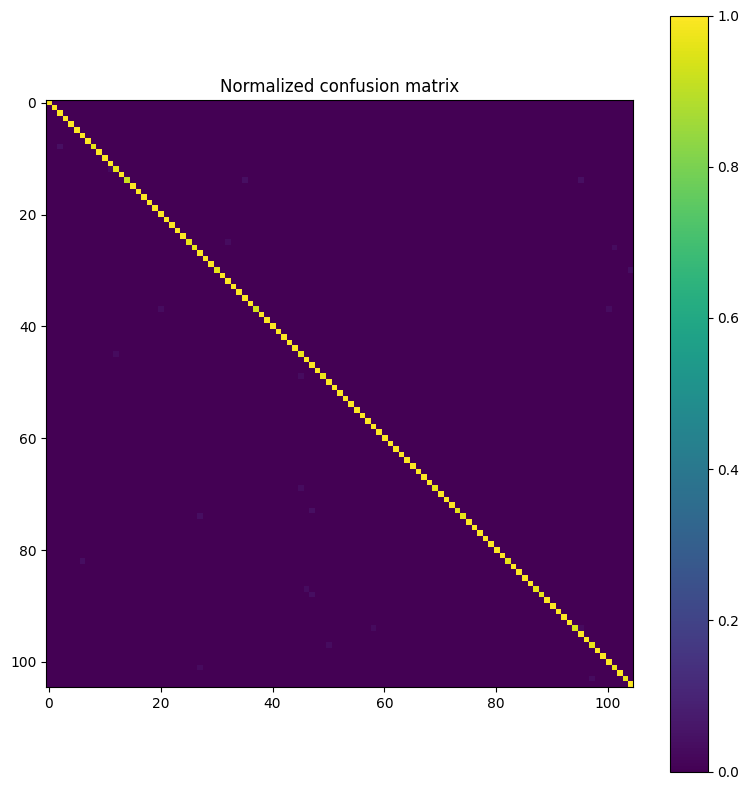

5-fold CV: mean=0.9917 std=0.0013
Saved centroids to embeddings_cache\centroids.npy and classes to embeddings_cache\classes.npy
Centroid baseline accuracy: 0.9870771569745344
Suggested cosine threshold for open-set (approx TPR=0.95): 0.4617


In [13]:
# Block 8 — evaluation: classification report, confusion matrix, 5-fold CV, centroid baseline, threshold
import pickle, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize

# load saved classifier
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']; le = obj['le']; norm = obj['norm']
X_test = obj['X_test']; y_test = obj['y_test']

# report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred).astype(float)
cmn = cm / cm.sum(axis=1)[:, None]
plt.figure(figsize=(8,8)); plt.imshow(cmn); plt.title('Normalized confusion matrix'); plt.colorbar(); plt.tight_layout(); plt.show()

# 5-fold CV on full dataset
X_all = np.load(EMB_FILE); y_all = np.load(LBL_FILE, allow_pickle=True)
y_all_enc = le.transform(y_all); Xn_all = norm.transform(X_all)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs = []
for tr, te in skf.split(Xn_all, y_all_enc):
    clf.fit(Xn_all[tr], y_all_enc[tr])
    accs.append(clf.score(Xn_all[te], y_all_enc[te]))
print("5-fold CV: mean={:.4f} std={:.4f}".format(np.mean(accs), np.std(accs)))

# centroid baseline
Xn_norm = normalize(X_all, axis=1)
centroids = {c: Xn_norm[y_all_enc==c].mean(axis=0) for c in np.unique(y_all_enc)}
# save centroids and classes for lightweight inference
centroid_matrix = np.vstack([centroids[c] for c in sorted(centroids.keys())])
classes_order = np.array([le.classes_[c] for c in sorted(centroids.keys())])
np.save(CENTROIDS_FILE, centroid_matrix)
np.save(CLASSES_FILE, classes_order)
print("Saved centroids to", CENTROIDS_FILE, "and classes to", CLASSES_FILE)

# centroid accuracy on same test split
from sklearn.model_selection import train_test_split
_, X_test_c, _, y_test_c = train_test_split(Xn_norm, y_all_enc, stratify=y_all_enc, test_size=0.15, random_state=42)
def predict_centroid(emb):
    emb = emb / np.linalg.norm(emb)
    sims = centroid_matrix.dot(emb)
    return sims.argmax(), sims.max()
y_cent = [predict_centroid(e)[0] for e in X_test_c]
print("Centroid baseline accuracy:", accuracy_score(y_test_c, y_cent))

# Open-set threshold suggestion: compute genuine vs impostor cosine scores on validation set
# Build per-class centroid from training portion and compute scores: simple approach using split
tr, val = next(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(Xn_all, y_all_enc))
# compute centroids on tr
centroids_tr = {c: Xn_all[tr][y_all_enc[tr]==c].mean(axis=0) for c in np.unique(y_all_enc)}
# compute genuine scores and impostor scores on val set
genuine_scores = []
impostor_scores = []
for i, emb in enumerate(Xn_all[val]):
    label = y_all_enc[val][i]
    emb_norm = emb / np.linalg.norm(emb)
    sims = [emb_norm.dot(centroids_tr[c]) for c in centroids_tr]
    # genuine score = sim with true class centroid
    genuine_scores.append(emb_norm.dot(centroids_tr[label]))
    # impostor score = max sim to any other class centroid
    impostor_scores.append(max([s for c,s in zip(centroids_tr.keys(), sims) if c != label]))

genuine_scores = np.array(genuine_scores); impostor_scores = np.array(impostor_scores)
# compute ROC between genuine and impostor by labeling genuine=1, impostor=0 (stack arrays)
labels_scores = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
scores = np.concatenate([genuine_scores, impostor_scores])
fpr, tpr, thresholds = roc_curve(labels_scores, scores)
# pick threshold where tpr ~ 0.95 or where (tpr-fpr) is maximized
idx = (np.abs(tpr - 0.95)).argmin()
suggested_thresh = thresholds[idx]
print(f"Suggested cosine threshold for open-set (approx TPR=0.95): {suggested_thresh:.4f}")


In [14]:
# Block 9.1 — inference helpers (SVM and centroid)
import numpy as np, pickle, cv2, torch
from pathlib import Path
from sklearn.preprocessing import normalize

# load artifacts
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']; le = obj['le']; norm = obj['norm']
centroid_matrix = np.load(CENTROIDS_FILE)
classes_order = np.load(CLASSES_FILE)

def predict_with_svm(image_path, top_k=3):
    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    face = mtcnn(img)
    if face is None:
        return None
    if face.dim()==3: face = face.unsqueeze(0)
    with torch.no_grad():
        emb = resnet(face).cpu().numpy().reshape(1,-1)
    emb = norm.transform(emb)
    probs = clf.predict_proba(emb)[0]
    idx = probs.argsort()[::-1][:top_k]
    return [(le.classes_[i], float(probs[i])) for i in idx]

def predict_with_centroid(image_path, top_k=3):
    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    face = mtcnn(img)
    if face is None:
        return None
    if face.dim()==3: face = face.unsqueeze(0)
    with torch.no_grad():
        emb = resnet(face).cpu().numpy().reshape(-1)
    emb = emb / np.linalg.norm(emb)
    sims = centroid_matrix.dot(emb)
    idx = sims.argsort()[::-1][:top_k]
    return [(classes_order[i], float(sims[i])) for i in idx]

print("Inference helpers ready. Example:")
# print(predict_with_centroid('path/to/example.jpg'))


Inference helpers ready. Example:


In [15]:
# Block 9.2

# centroid baseline
from sklearn.preprocessing import normalize
X = np.load('./embeddings_cache/X_emb.npy'); y = np.load('./embeddings_cache/y_lbl.npy')
le = LabelEncoder().fit(y); y_enc = le.transform(y)
Xn = normalize(X, axis=1)
centroids = {c: Xn[y_enc==c].mean(axis=0) for c in np.unique(y_enc)}

# test set predictions (use previous X_test,y_test from split or re-split similarly)
import numpy as np
def predict_centroid(emb):
    emb = emb/np.linalg.norm(emb)
    sims = [(c, emb.dot(centroids[c])) for c in centroids] 
    return max(sims, key=lambda x: x[1])[0]

y_cent = [predict_centroid(e) for e in X_test]  # X_test must be normalized rows
# map centroids' indices -> label names (if needed)
from sklearn.metrics import accuracy_score
print("Centroid accuracy on test:", accuracy_score(y_test, y_cent))

# centroid baseline
from sklearn.preprocessing import normalize
X = np.load('./embeddings_cache/X_emb.npy'); y = np.load('./embeddings_cache/y_lbl.npy')
le = LabelEncoder().fit(y); y_enc = le.transform(y)
Xn = normalize(X, axis=1)
centroids = {c: Xn[y_enc==c].mean(axis=0) for c in np.unique(y_enc)}

# test set predictions (use previous X_test,y_test from split or re-split similarly)
import numpy as np
def predict_centroid(emb):
    emb = emb/np.linalg.norm(emb)
    sims = [(c, emb.dot(centroids[c])) for c in centroids]
    return max(sims, key=lambda x: x[1])[0]

y_cent = [predict_centroid(e) for e in X_test]  # X_test must be normalized rows
# map centroids' indices -> label names (if needed)
from sklearn.metrics import accuracy_score
print("Centroid accuracy on test:", accuracy_score(y_test, y_cent))


Centroid accuracy on test: 0.985546218487395
Centroid accuracy on test: 0.985546218487395


In [16]:
# Block 10 - Predict on images and generate detailed CSV report
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
import cv2
import torch
from PIL import Image

# ---------- EDIT THIS: Path to folder containing images to predict ----------
PREDICT_DIR = "human_face_dataset/pins_face_recognition"  # << CHANGE THIS to your test images folder
# ----------------------------------------------------------------------------

# Output CSV paths
OUTPUT_CSV = "predictions_results.csv"
OUTPUT_SUMMARY_CSV = "predictions_summary.csv"

# Load trained model and artifacts
print("Loading trained model...")
obj = pickle.load(open(CLF_FILE, 'rb'))
clf = obj['clf']
le = obj['le']
norm = obj['norm']
print(f"✅ Model loaded. Can recognize {len(le.classes_)} classes")

# Get all image files
PREDICT_PATH = Path(PREDICT_DIR)
image_paths = [str(p) for p in sorted(PREDICT_PATH.rglob('*')) if p.suffix.lower() in EXTS]
print(f"Found {len(image_paths)} images in {PREDICT_DIR}")

if len(image_paths) == 0:
    print("⚠️ No images found! Check PREDICT_DIR path.")
else:
    # Prepare results storage
    results = []
    failed_images = []

    print("\nProcessing images...")
    for img_path in tqdm(image_paths, desc='Predicting'):
        try:
            # Load and process image
            img = Image.open(img_path).convert('RGB')

            # Resize if too large (speed optimization)
            w, h = img.size
            max_side = 640
            if max(w, h) > max_side:
                scale = max_side / max(w, h)
                img = img.resize((int(w*scale), int(h*scale)), Image.BILINEAR)

            # Detect face
            face = mtcnn(img)

            if face is None:
                failed_images.append((img_path, "No face detected"))
                continue

            # Ensure correct dimensions
            if face.dim() == 3:
                face = face.unsqueeze(0)

            # Get embedding
            with torch.no_grad():
                emb = resnet(face).cpu().numpy().reshape(1, -1)

            # Normalize
            emb_norm = norm.transform(emb)

            # Predict
            pred_class = clf.predict(emb_norm)[0]
            pred_label = le.inverse_transform([pred_class])[0]

            # Get confidence (probability)
            proba = clf.predict_proba(emb_norm)[0]
            confidence = float(proba[pred_class])

            # Get top 3 predictions
            top3_idx = proba.argsort()[::-1][:3]
            top3_labels = le.inverse_transform(top3_idx)
            top3_probs = proba[top3_idx]

            # Get actual label (from parent folder name)
            actual_label = Path(img_path).parent.name

            # Check if correct
            is_correct = (actual_label == pred_label)

            # Store result
            results.append({
                'image_path': img_path,
                'filename': Path(img_path).name,
                'actual': actual_label,
                'predicted': pred_label,
                'confidence': confidence,
                'correct': is_correct,
                'status': 'CORRECT ✓' if is_correct else 'WRONG ✗',
                'top1': top3_labels[0],
                'top1_conf': float(top3_probs[0]),
                'top2': top3_labels[1] if len(top3_labels) > 1 else '',
                'top2_conf': float(top3_probs[1]) if len(top3_probs) > 1 else 0.0,
                'top3': top3_labels[2] if len(top3_labels) > 2 else '',
                'top3_conf': float(top3_probs[2]) if len(top3_probs) > 2 else 0.0
            })

        except Exception as e:
            failed_images.append((img_path, str(e)))

    # Create DataFrame
    if results:
        results_df = pd.DataFrame(results)

        # Sort: Correct predictions first (sorted by confidence desc), then wrong predictions
        results_df_sorted = pd.concat([
            results_df[results_df['correct']].sort_values('confidence', ascending=False),
            results_df[~results_df['correct']].sort_values('confidence', ascending=False)
        ])

        # Save complete results to CSV
        results_df_sorted.to_csv(OUTPUT_CSV, index=False)

        # Calculate statistics
        total_images = len(results)
        correct_count = results_df['correct'].sum()
        wrong_count = total_images - correct_count
        accuracy = correct_count / total_images if total_images > 0 else 0

        print("\n" + "="*80)
        print("📊 PREDICTION SUMMARY")
        print("="*80)
        print(f"✅ Total images processed: {total_images}")
        print(f"✅ Correct predictions: {correct_count} ({correct_count/total_images*100:.2f}%)")
        print(f"❌ Wrong predictions: {wrong_count} ({wrong_count/total_images*100:.2f}%)")
        print(f"📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"📊 Average confidence: {results_df['confidence'].mean():.4f}")
        print(f"❌ Failed to process: {len(failed_images)} images")

        # Per-class accuracy summary
        class_summary = results_df.groupby('actual').agg({
            'correct': ['sum', 'count', 'mean']
        }).reset_index()
        class_summary.columns = ['class_name', 'correct_count', 'total_count', 'accuracy']
        class_summary['wrong_count'] = class_summary['total_count'] - class_summary['correct_count']
        class_summary = class_summary.sort_values('accuracy', ascending=False)

        # Save class summary
        class_summary.to_csv(OUTPUT_SUMMARY_CSV, index=False)

        # Show wrong predictions details
        wrong_predictions = results_df[~results_df['correct']].copy()

        if len(wrong_predictions) > 0:
            print("\n" + "="*80)
            print(f"❌ WRONG PREDICTIONS DETAILS ({len(wrong_predictions)} total)")
            print("="*80)

            # Group wrong predictions by actual class
            wrong_by_class = wrong_predictions.groupby('actual').agg({
                'filename': 'count',
                'predicted': lambda x: ', '.join(x.value_counts().head(3).index.tolist())
            }).reset_index()
            wrong_by_class.columns = ['actual_class', 'wrong_count', 'predicted_as']
            wrong_by_class = wrong_by_class.sort_values('wrong_count', ascending=False)

            print("\nClasses with wrong predictions:")
            print(wrong_by_class.to_string(index=False))

            print("\n" + "-"*80)
            print("Individual wrong predictions (showing first 20):")
            print("-"*80)
            wrong_display = wrong_predictions[['filename', 'actual', 'predicted', 'confidence']].head(20)
            for idx, row in wrong_display.iterrows():
                print(f"  • {row['filename']}")
                print(f"    Actual: {row['actual']} → Predicted: {row['predicted']} (confidence: {row['confidence']:.3f})")

            if len(wrong_predictions) > 20:
                print(f"\n  ... and {len(wrong_predictions)-20} more wrong predictions (see CSV for details)")
        else:
            print("\n🎉 NO WRONG PREDICTIONS! Perfect accuracy!")

        # Show classes with perfect accuracy
        perfect_classes = class_summary[class_summary['accuracy'] == 1.0]
        if len(perfect_classes) > 0:
            print("\n" + "="*80)
            print(f"🎯 CLASSES WITH 100% ACCURACY ({len(perfect_classes)} classes)")
            print("="*80)
            print(perfect_classes[['class_name', 'total_count']].head(20).to_string(index=False))
            if len(perfect_classes) > 20:
                print(f"... and {len(perfect_classes)-20} more classes")

        # Show classes with lowest accuracy
        print("\n" + "="*80)
        print("⚠️ CLASSES WITH LOWEST ACCURACY (Bottom 10)")
        print("="*80)
        print(class_summary[['class_name', 'correct_count', 'wrong_count', 'total_count', 'accuracy']].tail(10).to_string(index=False))

        # Show correct predictions sample
        correct_predictions = results_df[results_df['correct']]
        print("\n" + "="*80)
        print(f"✅ CORRECT PREDICTIONS SAMPLE (showing 10 of {len(correct_predictions)})")
        print("="*80)
        correct_display = correct_predictions[['filename', 'actual', 'confidence']].head(10)
        for idx, row in correct_display.iterrows():
            print(f"  ✓ {row['filename']}: {row['actual']} (confidence: {row['confidence']:.3f})")

        print("\n" + "="*80)
        print("📁 OUTPUT FILES SAVED:")
        print("="*80)
        print(f"✅ {OUTPUT_CSV}")
        print(f"   → All predictions sorted (correct first, then wrong)")
        print(f"   → Columns: filename, actual, predicted, confidence, status, top3")
        print(f"\n✅ {OUTPUT_SUMMARY_CSV}")
        print(f"   → Per-class accuracy summary")
        print(f"   → Columns: class_name, correct_count, wrong_count, total_count, accuracy")
        print("="*80)

    # Show failed images
    if failed_images:
        print("\n" + "="*80)
        print(f"❌ FAILED TO PROCESS ({len(failed_images)} images)")
        print("="*80)
        for path, reason in failed_images[:20]:
            print(f"  • {Path(path).name}: {reason}")
        if len(failed_images) > 20:
            print(f"  ... and {len(failed_images)-20} more")

        # Save failed images list
        failed_df = pd.DataFrame(failed_images, columns=['image_path', 'error'])
        failed_df.to_csv('failed_predictions.csv', index=False)
        print(f"\n✅ Failed images list saved to: failed_predictions.csv")

print("\n" + "="*80)
print("✅ PROCESSING COMPLETE!")
print("="*80)

Loading trained model...
✅ Model loaded. Can recognize 105 classes
Found 17534 images in human_face_dataset/pins_face_recognition

Processing images...


Predicting: 100%|██████████████████████████████████████████████████████████████| 17534/17534 [1:42:42<00:00,  2.85it/s]



📊 PREDICTION SUMMARY
✅ Total images processed: 17486
✅ Correct predictions: 17442 (99.75%)
❌ Wrong predictions: 44 (0.25%)
📊 Overall Accuracy: 0.9975 (99.75%)
📊 Average confidence: 0.8239
❌ Failed to process: 48 images

❌ WRONG PREDICTIONS DETAILS (44 total)

Classes with wrong predictions:
            actual_class  wrong_count                                                        predicted_as
        pins_Brie Larson            4            pins_Emma Stone, pins_ellen page, pins_Jennifer Lawrence
     pins_Jessica Barden            3     pins_Alex Lawther, pins_kiernen shipka, pins_Danielle Panabaker
       pins_Logan Lerman            3 pins_Sarah Wayne Callies, pins_Leonardo DiCaprio, pins_Eliza Taylor
 pins_scarlett johansson            2                                   pins_gal gadot, pins_Taylor Swift
      pins_Emilia Clarke            2                           pins_Marie Avgeropoulos, pins_Irina Shayk
   pins_Brenton Thwaites            2                           pins_Le